# Generative Models

<figure>
    <img src="https://drive.google.com/uc?export=view&id=1woDSS8Z89hCcM9OOBPePMW4YZ70bZWUb" alt="Picture" style="display: block; margin: 0 auto;" />
    <figcaption style="text-align: center;"><strong>Fig. 1: Face Generation using GAN. Source: <a href="https://www.eff.org/files/2018/02/20/malicious_ai_report_final.pdf">https://www.eff.org/files/2018/02/20/malicious_ai_report_final.pdf</a></strong></figcaption>
</figure>



In [26]:
#@title Imports

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

import matplotlib.pyplot as plt

import tensorflow as tf

from torch.utils.data import DataLoader

In [27]:
#@title Auxiliary Functions

class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(x.size(0), *self.shape)


def generate_noise(batch_size, noise_dim):
    return torch.randn(batch_size, noise_dim, 1, 1).to(device)

def generate_images(generator):
    noise = generate_noise(25, 100)

    generator.eval()
    generated_images = generator(noise)
    generated_images = generated_images.view(25, 28, 28).detach().cpu().numpy()

    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i], cmap='gray')
        ax.axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [28]:
#@title Dataset

transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = datasets.MNIST(root='MNIST_data/', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='MNIST_data/', train=False, download=True, transform=transform)

#trainset = Subset(trainset, range(0, len(trainset)//10))
#testset = Subset(testset, range(0, len(testset)//10))

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=True)

# Variational Auto-Encoders

> #### **Exercise:** Using the MNIST dataset train a variational autoencoder. To do this you must implement the encoder, the decoder, the reparametrize trick, and the loss function. Then, show the generated latent space. Finally, analyze the obtained results.

### Encoder

|Layer (Type)| Output Shape |
|-|-|
| Input Layer | (28, 28, 1) |
| Conv2D | (28, 28, 32) |
| Conv2D | (14, 14, 32) |
| Conv2D | (14, 14, 64) |
| Flatten | 14x14x64 |
| Dense $(z \ \mu)$  | Latent Dim |
| Dense $(z \ log \ var)$ | Latent Dim |
| Sampling($z$) | Latent Dim |

Activation Functions: ReLU


In [29]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=5):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1) # Mantiene tamaño 28x28
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1) # Reduce a 14x14
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # Mantiene tamaño 14x14

        # Fully connected layers para 𝑧 𝜇 y 𝑧 𝑙𝑜𝑔 𝑣𝑎𝑟
        self.fc1 = nn.Linear(14*14*64, self.latent_dim) # Para mu
        self.fc2 = nn.Linear(14*14*64, self.latent_dim) # Para log_var

    # Reparametrization Trick (Sampling)
    def sampling(self, mu, log_var):
        # La desviación estándar es el exponencial del log varianza dividido 2
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)  # eps tiene la misma forma que std
        return mu + eps*std

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Aplanamos desde la dimensión 1, manteniendo la dimensión del lote intacta
        x = torch.flatten(x, start_dim=1)
        mu = self.fc1(x)
        log_var = self.fc2(x)
        z = self.sampling(mu, log_var)
        return z, mu, log_var


### Decoder

| Layer (Type)                | Output Shape |
|-----------------------------|--------------|
| Dense        | (Latent Dim, 14x14x64)    |
| Reshape                     | (64, 14, 14)   |
| ConvTranspose2D | (32, 28, 28) |
| ConvTranspose2D | (28, 28, 1) |
| ConvTranspose2D | (28, 28, 1)  |

Activation Functions:
- ReLU and Sigmoid for the output layer

In [30]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=5):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        # Dimensiones para la capa densa
        self.fc = nn.Linear(self.latent_dim, 14*14*64)

        # Convolutional Transpose Layers para reconstruir la imagen desde el espacio latente
        self.conv2d_transpose1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv2d_transpose2 = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.conv2d_transpose3 = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 64, 14, 14)  # Reshape a (64, 14, 14) antes de aplicar las capas convolucionales transpuestas
        x = F.relu(self.conv2d_transpose1(x))
        x = F.relu(self.conv2d_transpose2(x))
        x = torch.sigmoid(self.conv2d_transpose3(x))  # Usa sigmoid en la última capa para la salida
        return x


### VAE Model

In [31]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z, mu, log_var = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, mu, log_var

    def loss(self, x, x_hat, mu, log_var):
        # Divergencia KL: Mide cuán diferente es la distribución aprendida de una Gaussiana estándar
        KL_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Pérdida de reconstrucción: MSE entre la imagen original y la reconstruida
        reconstruction_loss = F.mse_loss(x_hat, x, reduction='sum')

        return KL_divergence + reconstruction_loss


In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train(model, trainloader, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        for i, (x, _) in enumerate(trainloader):
            x = x.to(device)
            x_hat, mu, log_var = model(x)
            loss = model.loss(x, x_hat, mu, log_var)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % 100 == 0:
                print(f'\rEpoch {epoch}, Iteration {i}, Loss: {loss.item():.4f}', end="")

train(model, trainloader, optimizer, epochs=5)

Epoch 4, Iteration 1800, Loss: 1080.1945

### Latent Space

In [33]:
# Plot latent space with labels
import numpy as np
from sklearn.manifold import TSNE
from sklearn.manifold import MDS

model.eval()
z = []
labels = []
with torch.no_grad():
    for x, y in testloader:
        x = x.to(device)
        z_, _, _ = model.encoder(x)
        z.append(z_.cpu().numpy())
        labels.append(y.numpy())

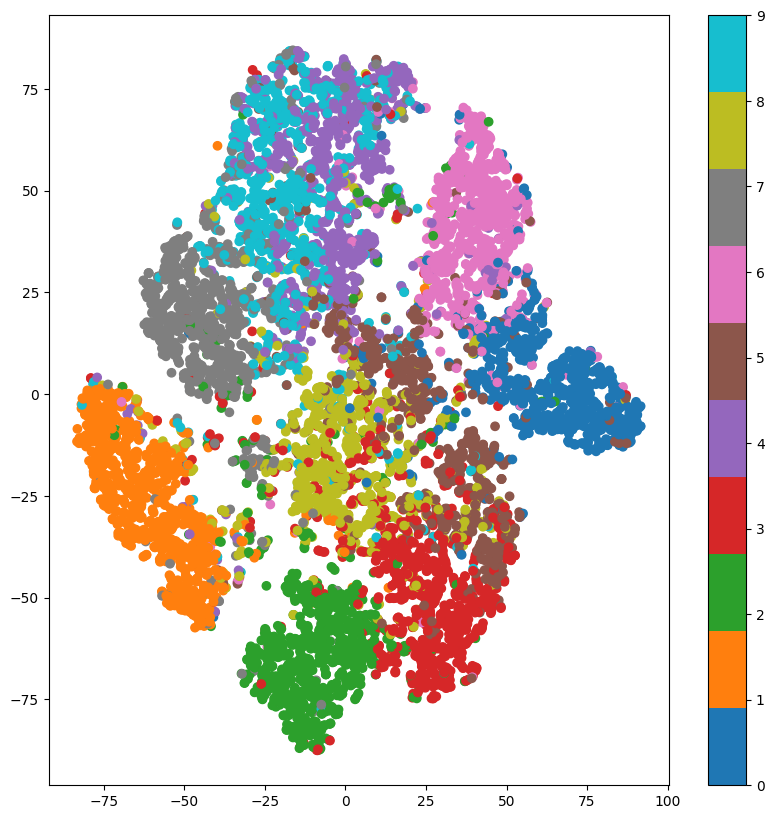

In [34]:
# MDS
z = np.concatenate(z)
#mds = MDS(n_components=2)
tsne = TSNE(n_components=2)
z = tsne.fit_transform(z)

labels = np.concatenate(labels)
plt.figure(figsize=(10, 10))
plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10')
plt.colorbar()
plt.show()

### Latent Space (Numbers)

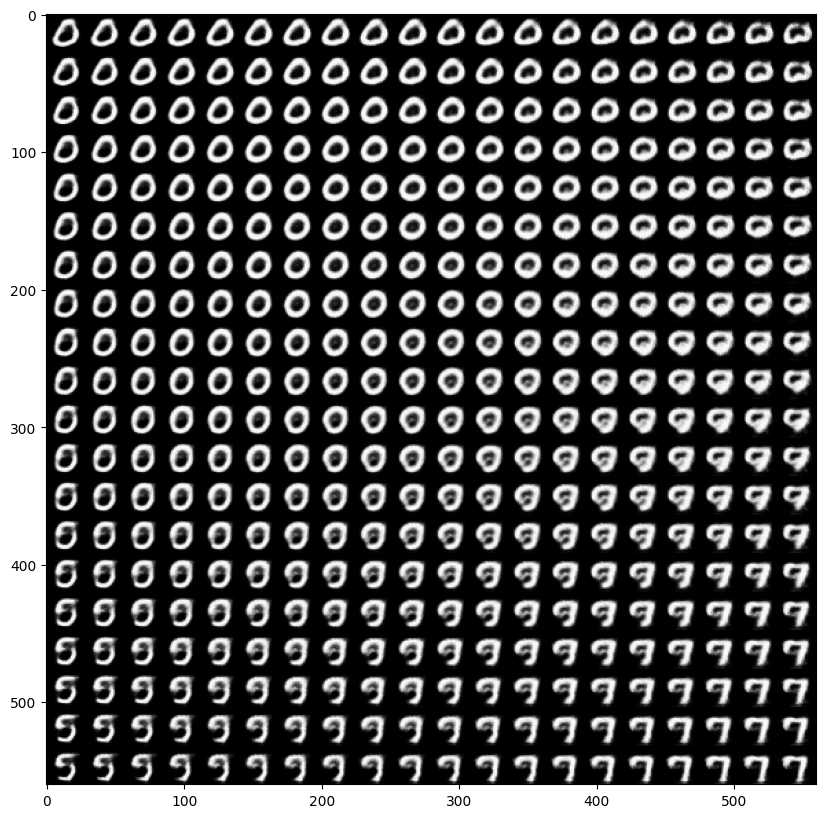

In [43]:
from scipy.stats import norm
n = 20  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

model.eval()
with torch.no_grad():
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            # with 5 latent vaariables, we can only visualize 2 dimensions
            # so we fix the other dimensions to 1
            z_sample = np.array([[xi, yi, 1, 1, 1]])
            z_sample = np.tile(z_sample, 32).reshape(32, 5)
            z_sample = torch.tensor(z_sample, dtype=torch.float32).to(device)
            x_decoded = model.decoder(z_sample)
            x_decoded = x_decoded.cpu().numpy()
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.show()

### Reconstructions

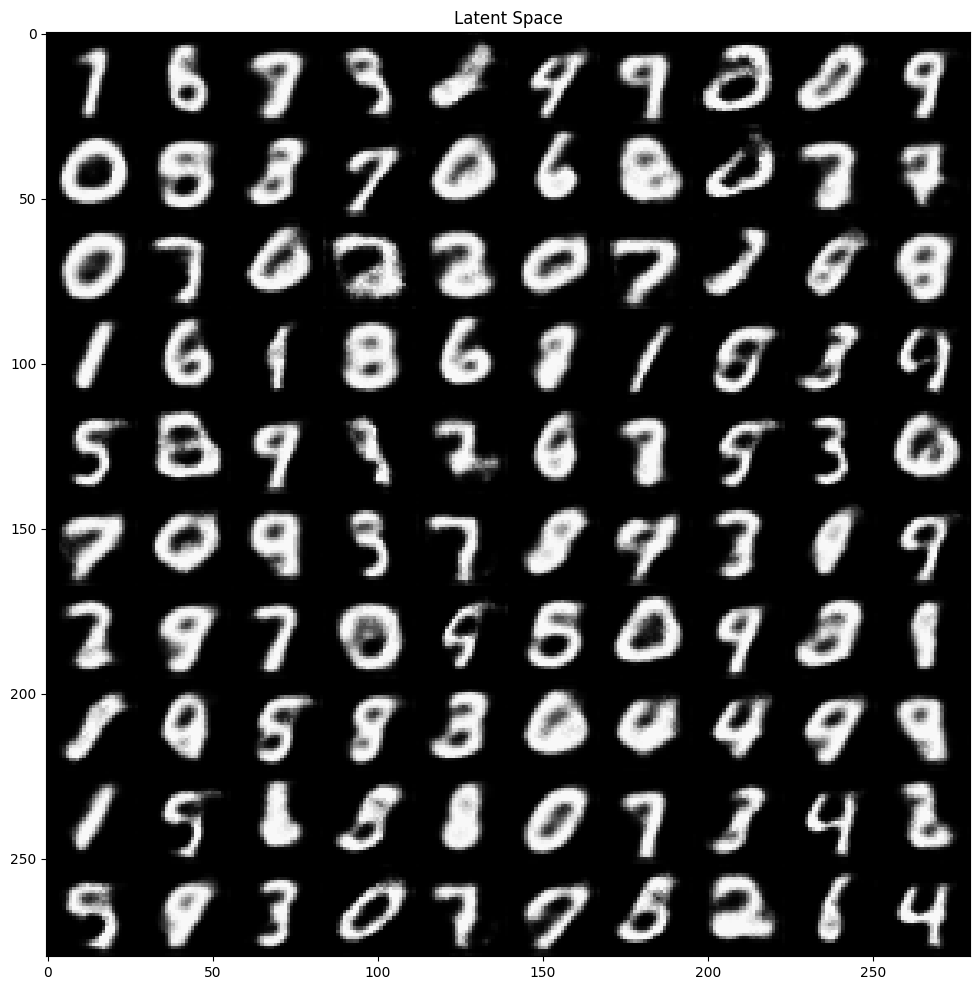

In [44]:

# Grid with numbers sampled from the latent space
import numpy as np
def plot_images(rows, cols, images, title):
    '''Displays images in a grid.'''
    images = images.reshape(rows, cols, 28, 28)  # Reshape images array
    grid = np.zeros(shape=(rows*28, cols*28))
    for i in range(rows):
        for j in range(cols):
            grid[i*28:(i+1)*28, j*28:(j+1)*28] = images[i, j]


    plt.figure(figsize=(12,12))
    plt.imshow(grid, cmap='gray')
    plt.title(title)
    plt.show()

model.eval()
n = 10
# Use normal distribution to sample from latent space
latent_space = torch.randn(n*n, model.encoder.latent_dim).to(device)
images = model.decoder(latent_space).view(-1, 1, 28, 28).cpu().detach().numpy()
plot_images(n, n, images, 'Latent Space')

> ### **Exercise:**  Adapt the loss function to use the hyperparameter $\beta$. Then, check how the modification of this parameter influences the generation of the latent space.

In [45]:
class VAE(nn.Module):
    def __init__(self, beta=1.0):
        super(VAE, self).__init__()
        self.beta = beta  # Añadir beta como un hiperparámetro de la clase
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z, mu, log_var = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, mu, log_var

    def loss(self, x, x_hat, mu, log_var):
        # Divergencia KL con el factor beta aplicado
        KL_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        reconstruction_loss = F.mse_loss(x_hat, x, reduction='sum')
        # Aplicar el factor beta solo al término de KL
        return self.beta * KL_divergence + reconstruction_loss


https://openreview.net/pdf?id=Sy2fzU9gl

# Generative Adversarial Networks

> ### **Exercise:** Implement the Generator and the Discriminator. Then generate some samples and plot the loss of the generator and discriminator.

### Generator

---
   |Layer (type)     |          Output Shape |
   |--|--|
   |ConvTranspose2d      |     [128, 7, 7]    |
   |ConvTranspose2d      |     [128, 7, 7]    |
   |           ReLU      |         |
   |ConvTranspose2d      |     [64, 14, 14]    |
   |ConvTranspose2d      |     [64, 14, 14]    |
   |           ReLU      |         |
   |ConvTranspose2d      |     [1, 28, 28]    |
   |ConvTranspose2d      |     [1, 28, 28]    |
   |           Tanh      |         |
   
   ---


In [38]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        # Define las capas ConvTranspose2d según las especificaciones
        self.generator = nn.Sequential(
            # Primer bloque: de [latent_dim, 1, 1] a [128, 7, 7]
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=7, stride=1, padding=0),
            nn.ReLU(True),
            # Agregando una capa adicional para experimentar (si es necesario, se puede eliminar)
            nn.ConvTranspose2d(128, 128, kernel_size=1, stride=1, padding=0),
            nn.ReLU(True),

            # Segundo bloque: de [128, 7, 7] a [64, 14, 14]
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            # Agregando una capa adicional para experimentar (si es necesario, se puede eliminar)
            nn.ConvTranspose2d(64, 64, kernel_size=1, stride=1, padding=0),
            nn.ReLU(True),

            # Tercer bloque: de [64, 14, 14] a [1, 28, 28]
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
            # La capa final Tanh ajusta los valores de salida al rango [-1, 1]
        )

    def forward(self, x):
        return self.generator(x)


### Discriminator

---
| Layer (type)      |         Output Shape  |
|--|--|
|      Conv2d        |   [64, 14, 14]   |
|      Conv2d        |   [64, 14, 14]   |
|   ReLU        |      |
|      Conv2d        |   [128, 7, 7]   |
|      Conv2d        |   [128, 7, 7]   |
|   ReLU        |      |
|      Conv2d        |   [1, 1, 1]   |
|      Conv2d        |   [1, 1, 1]   |
|     Sigmoid        |      |
---

In [39]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Definir las capas Conv2d según las especificaciones
        self.discriminator = nn.Sequential(
            # Primer bloque: [1, 28, 28] a [64, 14, 14]
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            # Agregando una capa adicional para experimentar (si es necesario, se puede eliminar)
            nn.Conv2d(64, 64, kernel_size=1, stride=1, padding=0),
            nn.ReLU(True),

            # Segundo bloque: [64, 14, 14] a [128, 7, 7]
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            # Agregando una capa adicional para experimentar (si es necesario, se puede eliminar)
            nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0),
            nn.ReLU(True),

            # Tercer bloque: [128, 7, 7] a [1, 1, 1]
            nn.Conv2d(128, 1, kernel_size=7, stride=1, padding=0),
            nn.Sigmoid()
            # La capa final Sigmoid ajusta los valores de salida al rango [0, 1]
        )

    def forward(self, x):
        return self.discriminator(x)


### Training

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.00005)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.00005)

loss_generator_iters = []
loss_discriminator_iters = []

def train():
    # Real and Fake labels
    real_label, fake_label = 1, 0

    # Loss function
    criterion = nn.BCELoss()

    for epoch in range(5):

        for i, (real_images, _) in enumerate(trainloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            real_labels = torch.full((batch_size, 1,1,1), real_label, dtype=torch.float, device=device)
            fake_labels = torch.full((batch_size, 1,1,1), fake_label, dtype=torch.float, device=device)

            # Train the discriminator
            discriminator.zero_grad()
            output = discriminator(real_images)
            loss_real = criterion(output, real_labels)
            loss_real.backward()


            # Generate fake images
            noise = generate_noise(batch_size, 100)
            fake_images = generator(noise)
            output = discriminator(fake_images.detach())
            loss_fake = criterion(output, fake_labels)
            loss_fake.backward()


            discriminator_optimizer.step()

            # Train the generator
            generator.zero_grad()
            output = discriminator(fake_images)
            loss_generator = criterion(output, real_labels)
            loss_generator.backward()

            generator_optimizer.step()

            print(f'\rEpoch [{epoch}], Step [{i}/{len(trainloader)}], Loss D: {loss_real + loss_fake}, Loss G: {loss_generator}', end='')

        # Save images for plot on each epoch
        generate_images(generator)

        # Save losses
        loss_generator_iters.append(loss_generator.item())
        loss_discriminator_iters.append(loss_real.item() + loss_fake.item())

Epoch [0], Step [1874/1875], Loss D: 0.2923058569431305, Loss G: 3.4116294384002686

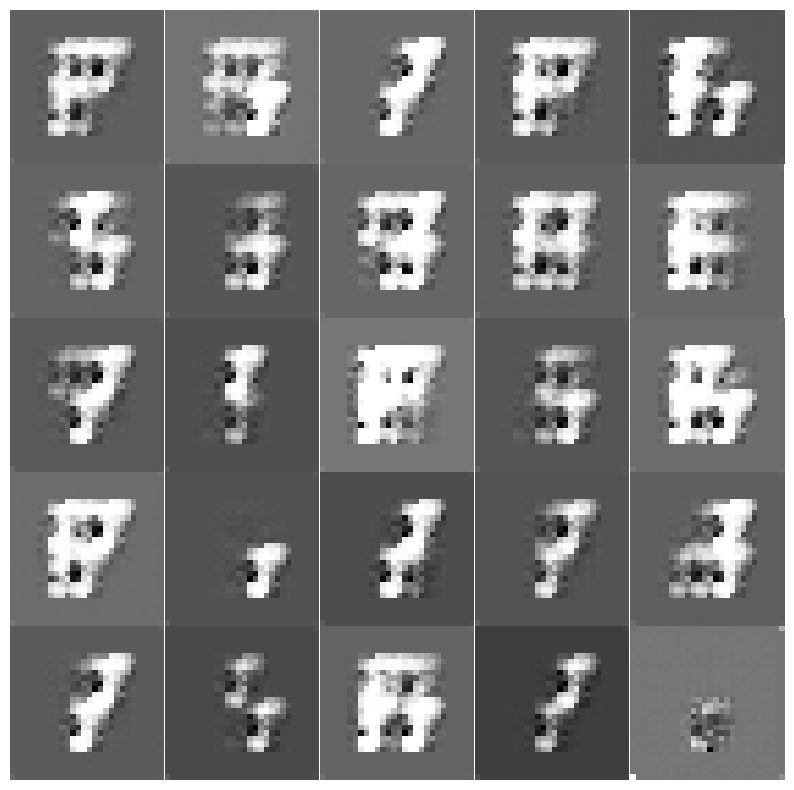

Epoch [1], Step [1874/1875], Loss D: 0.4014257490634918, Loss G: 3.712831497192383

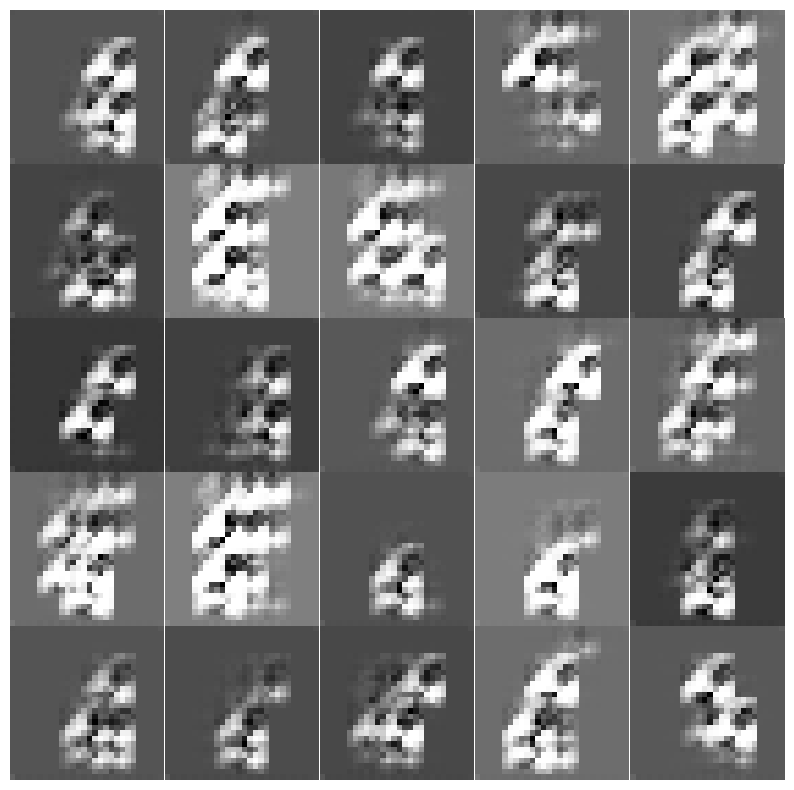

Epoch [2], Step [1874/1875], Loss D: 0.3343215882778168, Loss G: 5.202465057373047

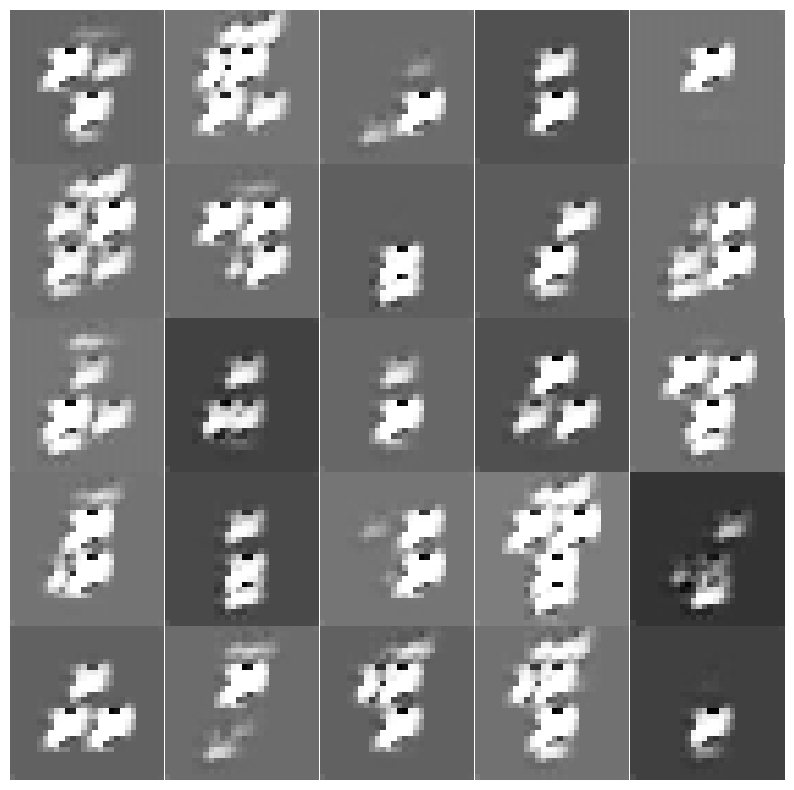

Epoch [3], Step [1874/1875], Loss D: 0.0520966500043869, Loss G: 5.4669647216796875

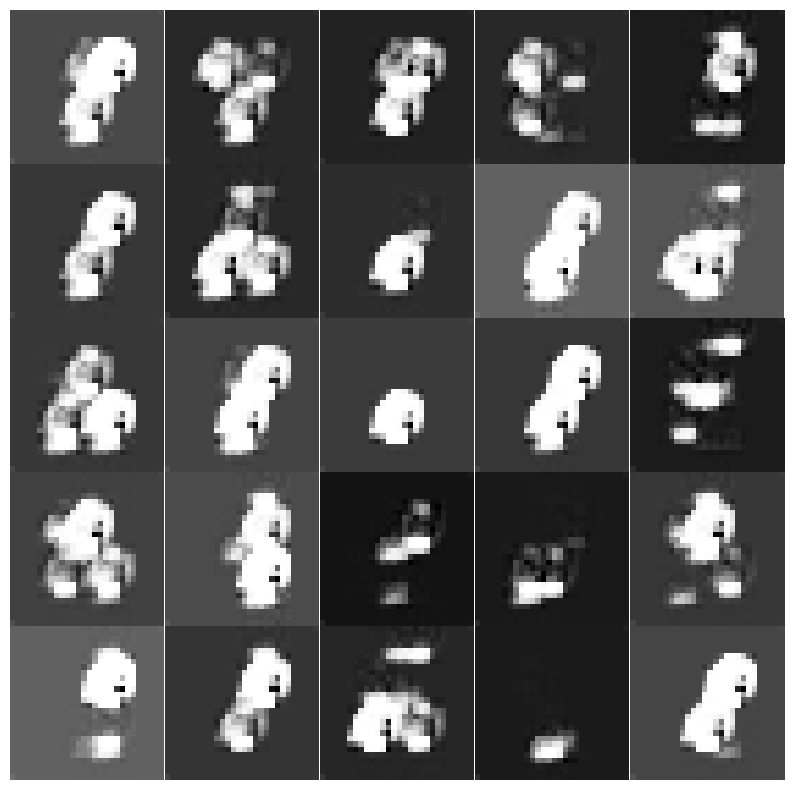

Epoch [4], Step [1874/1875], Loss D: 0.21420186758041382, Loss G: 4.626744270324707

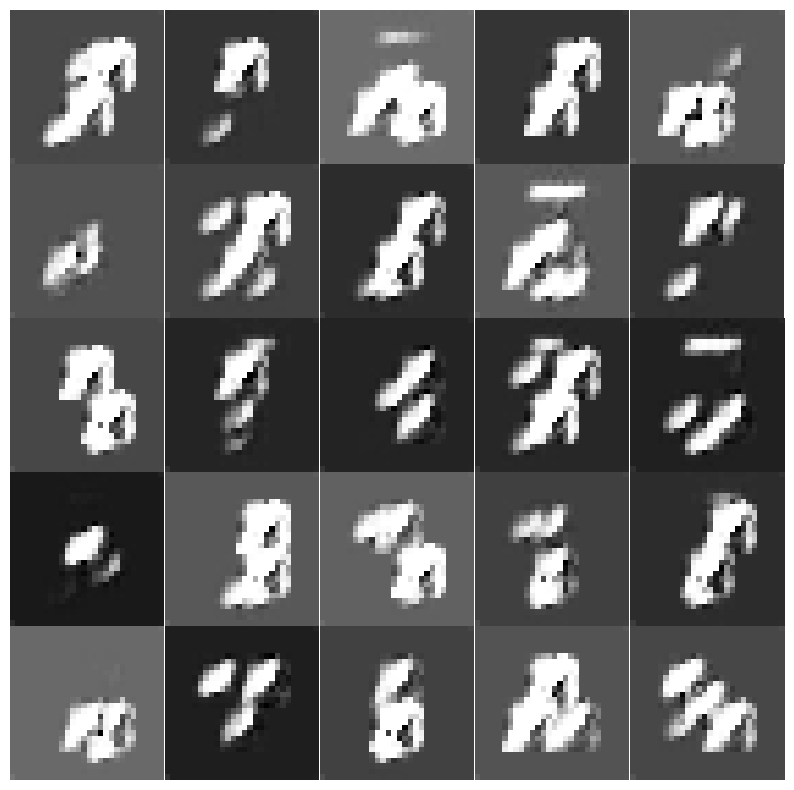

In [41]:
%matplotlib inline
train()

> ### **Exercise:** Improve the Generator and the Discriminator (you can add some Batch Normalization layers, dropout, etc). Then, generate new samples and compare the results.

In [49]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.generator(x)


In [50]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.Conv2d(128, 1, kernel_size=7, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.discriminator(x)


Epoch [0], Step [1874/1875], Loss D: 0.02604728192090988, Loss G: 4.062419414520264

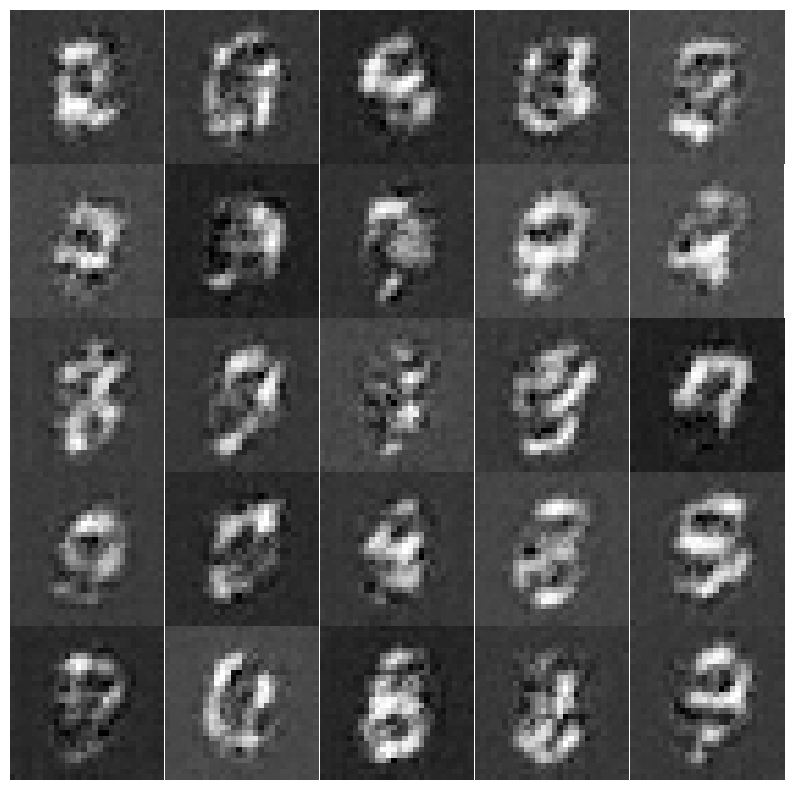

Epoch [1], Step [1874/1875], Loss D: 0.01832464709877968, Loss G: 5.746044635772705

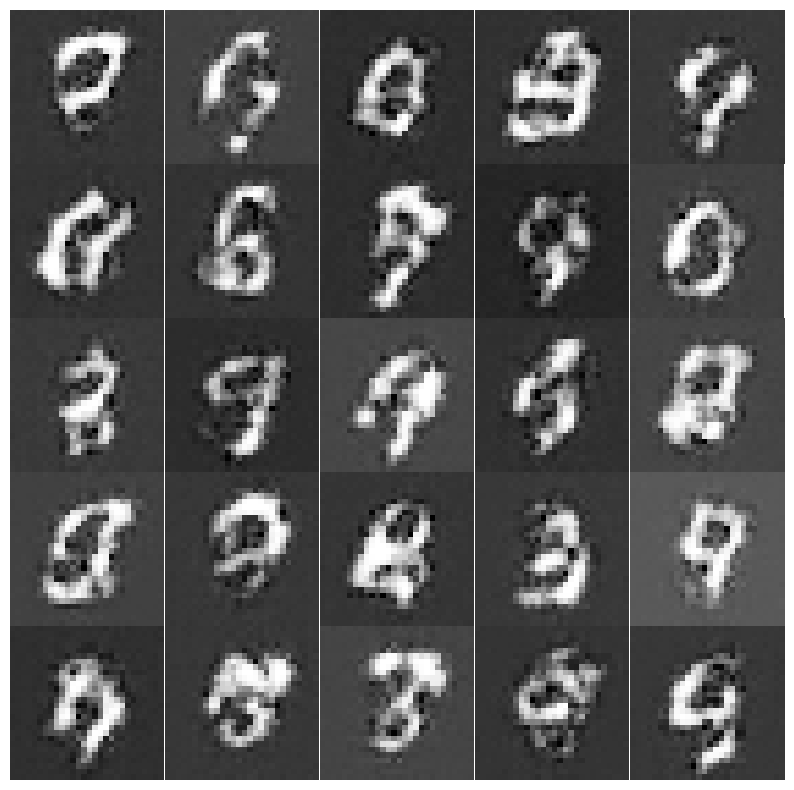

Epoch [2], Step [1874/1875], Loss D: 0.008924704976379871, Loss G: 6.195444583892822

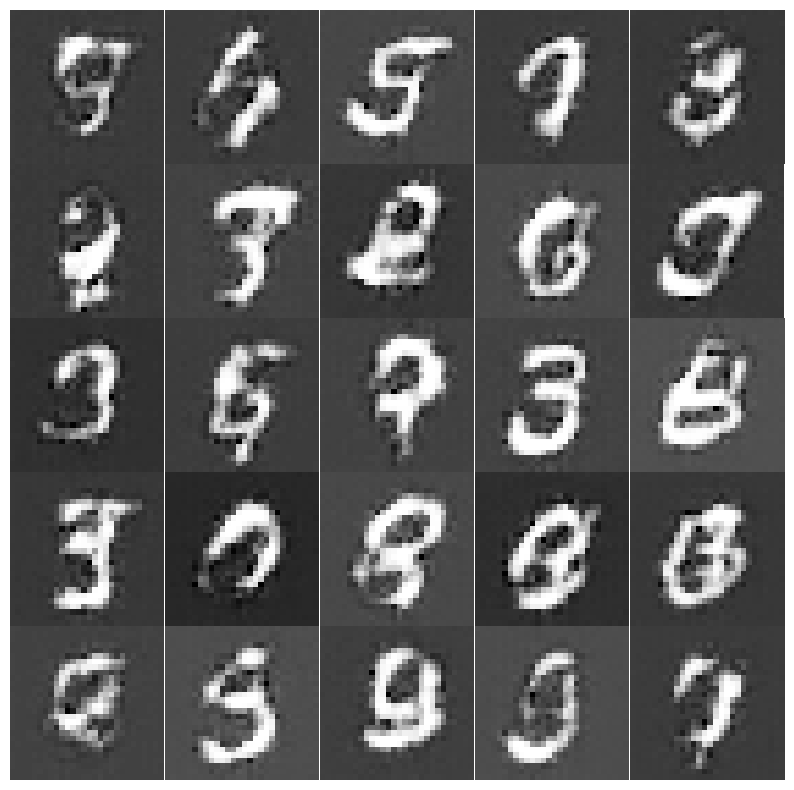

Epoch [3], Step [1874/1875], Loss D: 0.005430242046713829, Loss G: 6.766919136047363

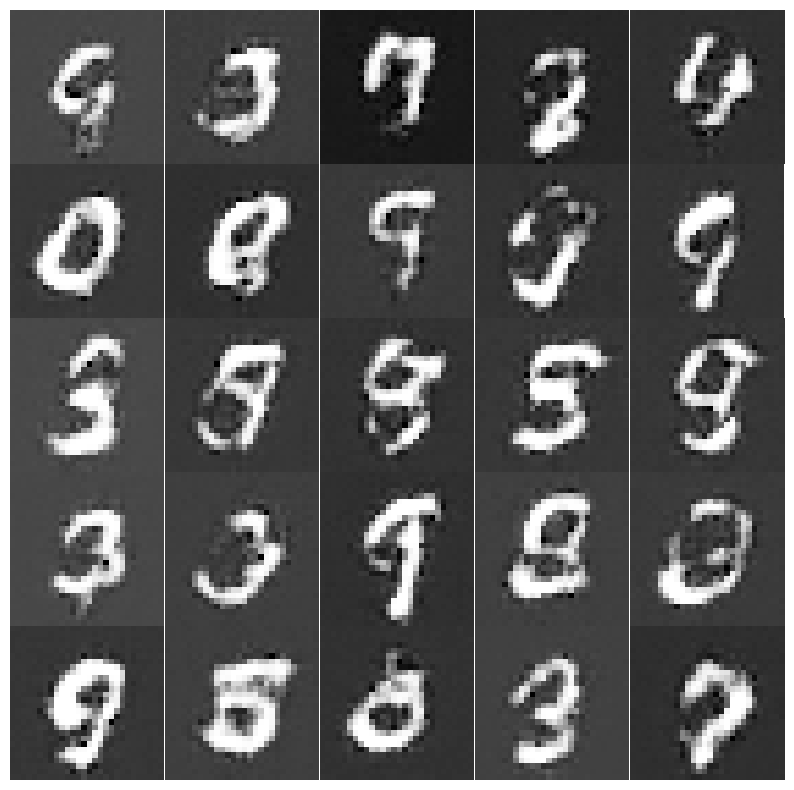

Epoch [4], Step [1874/1875], Loss D: 0.001258129021152854, Loss G: 8.37153434753418

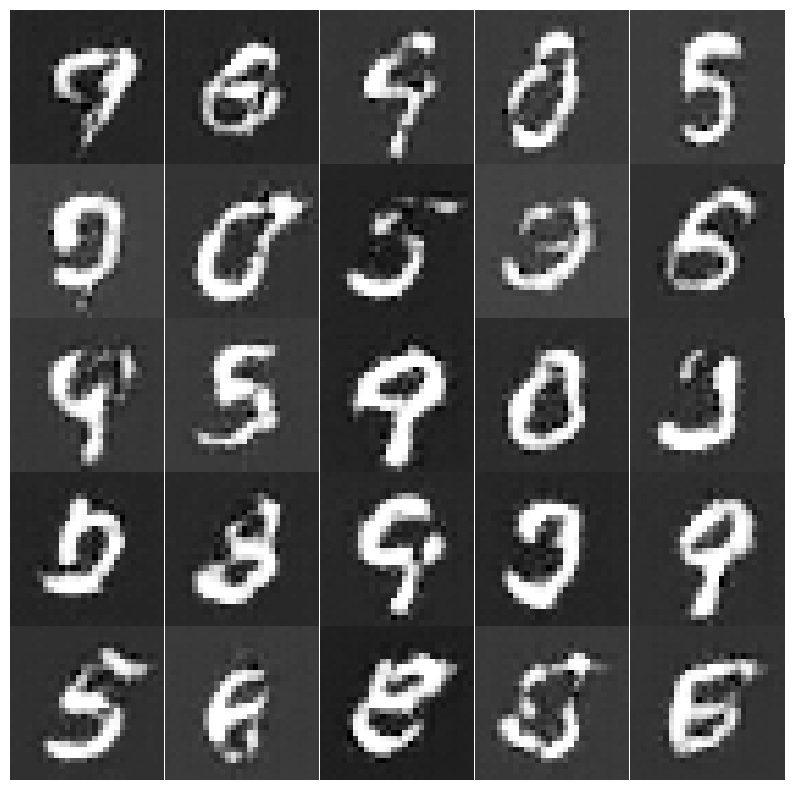

In [52]:
%matplotlib inline
train()

# Diffusion Networks

Reference: [Colab](https://colab.research.google.com/github/st-howard/blog-notebooks/blob/main/MNIST-Diffusion/Diffusion%20Digits%20-%20Generating%20MNIST%20Digits%20from%20noise%20with%20HuggingFace%20Diffusers.ipynb#scrollTo=a1a0807f)

In [1]:
%%capture
!pip install diffusers[training]==0.2.3

In [7]:
!pip install datasets
!pip install diffusers
!pip install accelerate


  Using cached accelerate-0.28.0-py3-none-any.whl (290 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 7.3 MB/s eta 0:00

In [77]:
# Imports

# Pytorch
import torch
import torchvision

# HuggingFace
import datasets
import diffusers
import accelerate

# Training and Visualization
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import os
import PIL
from torch.utils.data import DataLoader, Subset

In [78]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size=32 #Resize the digits to be a power of two
    train_batch_size = 32
    eval_batch_size = 32
    num_epochs = 5
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmpup_steps = 500
    mixed_precision = 'fp16'
    seed = 0

config = TrainingConfig()

mnist_dataset = datasets.load_dataset('mnist', split='train')

def transform(dataset):
    preprocess = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(
                (config.image_size, config.image_size)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Lambda(lambda x: 2*(x-0.5)),
        ]
    )
    images = [preprocess(image) for image in dataset["image"]]
    return {"images": images}

mnist_dataset.reset_format()
mnist_dataset.set_transform(transform)

mnist_dataset = Subset(mnist_dataset, range(20000))

train_dataloader = torch.utils.data.DataLoader(
    mnist_dataset,
    batch_size = config.train_batch_size,
    shuffle = True,
)

In [79]:
modelD = diffusers.UNet2DModel(
    sample_size=config.image_size,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(128,128,256,512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)


In [80]:
noise_scheduler = diffusers.DDPMScheduler(num_train_timesteps=200)


In [81]:
optimizer = torch.optim.AdamW(modelD.parameters(),lr=config.learning_rate)

In [82]:
# Cosine learning rate scheduler

lr_scheduler = diffusers.optimization.get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmpup_steps,
    num_training_steps=(len(train_dataloader)*config.num_epochs),
)

In [83]:
def train_loop(
        config,
        model,
        noise_scheduler,
        optimizer,
        train_dataloader,
        lr_scheduler):

    accelerator = accelerate.Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
    )

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader),
                            disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']

            noise = torch.randn(clean_images.shape).to(clean_images.device)
            batch_size = clean_images.shape[0]

            # Sample a set of random time steps for each image in mini-batch
            timesteps = torch.randint(
                0, noise_scheduler.num_train_timesteps, (batch_size,), device=clean_images.device)

            noisy_images=noise_scheduler.add_noise(clean_images, noise, timesteps.cpu())

            with accelerator.accumulate(model):
                noise_pred = model(noisy_images,timesteps)["sample"]
                loss = torch.nn.functional.mse_loss(noise_pred,noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(),1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {
                "loss" : loss.detach().item(),
                "lr" : lr_scheduler.get_last_lr()[0],
            }
            progress_bar.set_postfix(**logs)

    accelerator.unwrap_model(model)

In [84]:
args = (config, modelD, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

accelerate.notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

In [85]:
@torch.no_grad()
def sample(unet, scheduler, seed, save_process_dir=None):
    torch.manual_seed(seed)

    if save_process_dir:
        if not os.path.exists(save_process_dir):
            os.mkdir(save_process_dir)

    scheduler.set_timesteps(200)
    image = torch.randn((1, 1, 32, 32)).to(modelD.device)
    num_steps = max(noise_scheduler.timesteps).numpy()

    images = []
    for t in noise_scheduler.timesteps:
        model_output = unet(image, t)['sample']
        image = scheduler.step(model_output, int(t), image, generator=None)['prev_sample']

        if t % 10 == 0:
            save_image = torchvision.transforms.ToPILImage()(image.squeeze(0))
            images.append(save_image)


    return torchvision.transforms.ToPILImage()(image.squeeze(0)), images

def plot_images(images):
    fig, axs = plt.subplots(2, 10, figsize=(15, 6))
    for i in range(2):
        for j in range(10):
            axs[i, j].imshow(images[i * 10 + j], cmap='gray')
            axs[i, j].axis('off')
    plt.show()

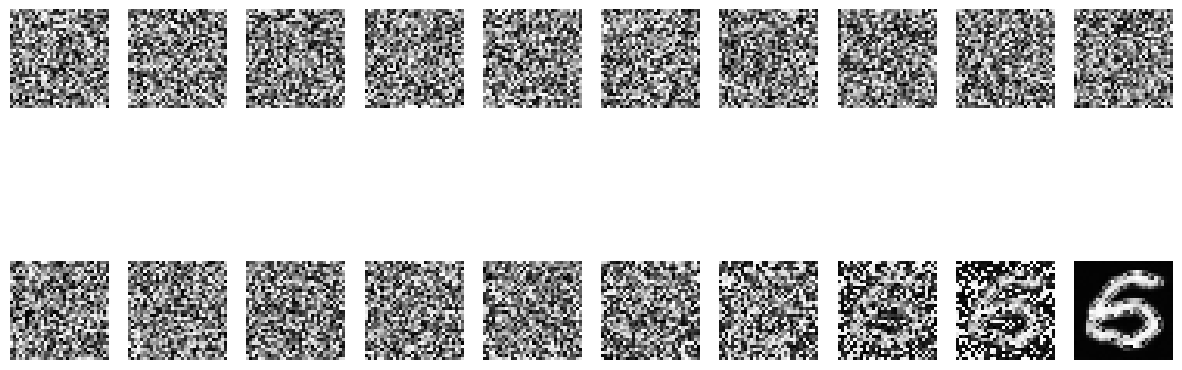

In [95]:
test_image, images = sample(modelD ,noise_scheduler, 2)
plot_images(images)

> ### **Exercise:** Compare the results with the GAN model. Change the noise used in the Diffusion Networks and generate new samples.

[Schedulers](https://huggingface.co/docs/diffusers/v0.3.0/en/api/schedulers#diffusers.DDPMScheduler)

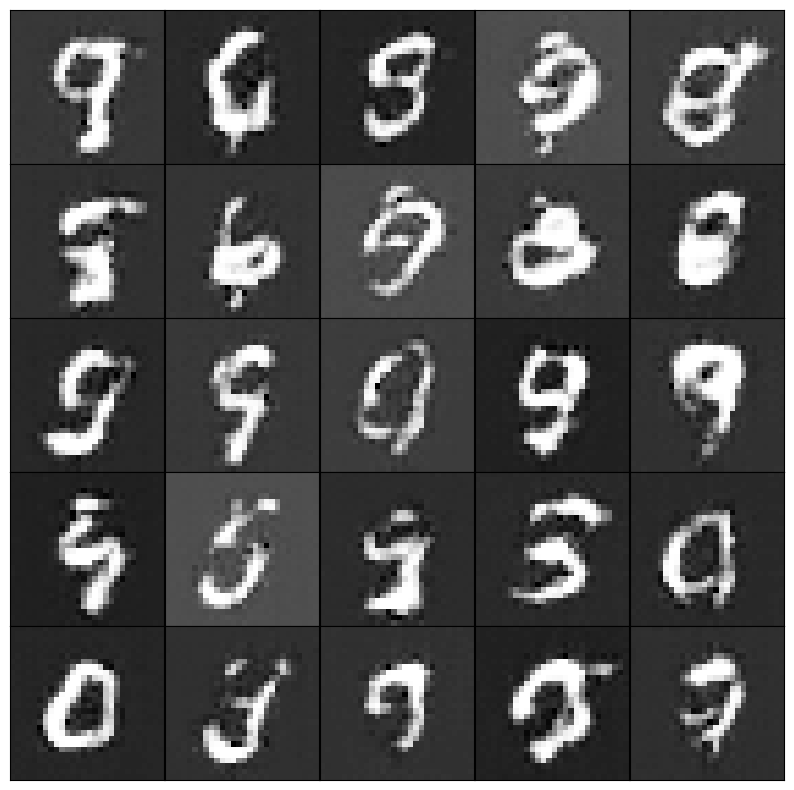

In [87]:
import matplotlib.pyplot as plt

def generate_samples_gan(generator, num_samples=25, latent_dim=100):
    with torch.no_grad():
        # Generar puntos en el espacio latente
        noise = torch.randn(num_samples, latent_dim, 1, 1).to(device)
        # Generar imágenes con el generador
        generated_images = generator(noise)
        return generated_images



def show_images(images, num_images=25):
    # Asumiendo que las imágenes están en (C, H, W) y en rango [-1, 1]
    images = images.cpu().detach()  # Asegurar que las imágenes estén en CPU para visualizar
    fig, axs = plt.subplots(figsize=(10, 10), nrows=5, ncols=5, sharey=True, sharex=True)
    for ax, img in zip(axs.flatten(), images):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        # Transformar rango de [-1, 1] a [0, 1] para mostrar correctamente
        img = (img + 1) / 2
        ax.imshow(img.permute(1, 2, 0).numpy(), cmap='gray')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

# Asumiendo que 'generator' es tu modelo y está en el 'device' correcto
generated_images = generate_samples_gan(generator, num_samples=25, latent_dim=100)
show_images(generated_images, num_images=25)


Al comparar Generative Adversarial Networks (GANs) con modelos de Diffusion, se observa que ambos enfoques son capaces de generar imágenes de alta calidad, mostrando similitudes notables en términos de realismo, detalle y diversidad. A pesar de sus diferencias fundamentales en la metodología—los GANs a través de una dinámica adversarial entre generador y discriminador, y los modelos de Diffusion mediante un proceso iterativo de añadir y quitar ruido—, los resultados finales demuestran que cada uno puede capturar con éxito la esencia del conjunto de datos objetivo. Esta similitud en los resultados subraya la potencia y la flexibilidad de las técnicas modernas de modelado generativo para la creación de contenido visual convincente.

